
### Implementação da PINN

In [5]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery
from diff_equations import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

In [2]:
np.random.seed(10)

Tenv = 25
T0 = 100
R = 0.005  #parametro que é dado, mas depois será previsto pela PINN
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)


In [6]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

Epoch 0/20000, loss: 4713.87
Epoch 2000/20000, loss: 2510.45
Epoch 4000/20000, loss: 2152.05
Epoch 6000/20000, loss: 757.46
Epoch 8000/20000, loss: 96.77
Epoch 10000/20000, loss: 1.76
Epoch 12000/20000, loss: 0.37
Epoch 14000/20000, loss: 0.35
Epoch 16000/20000, loss: 0.34
Epoch 18000/20000, loss: 0.33


In [7]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

In [8]:
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)


Epoch 0/20000, loss: 11219.99
Epoch 2000/20000, loss: 3894.98
Epoch 4000/20000, loss: 2434.00
Epoch 6000/20000, loss: 1620.68
Epoch 8000/20000, loss: 1205.04
Epoch 10000/20000, loss: 1014.87
Epoch 12000/20000, loss: 915.38
Epoch 14000/20000, loss: 840.63
Epoch 16000/20000, loss: 772.21
Epoch 18000/20000, loss: 710.80


In [9]:
predsreg = netreg.predict(times)

preds = net.predict(times)

In [10]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT

    return torch.mean(pde**2)

In [11]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

Epoch 0/30000, loss: 4775.84
Epoch 3000/30000, loss: 2435.01
Epoch 6000/30000, loss: 498.11
Epoch 9000/30000, loss: 0.98
Epoch 12000/30000, loss: 0.39
Epoch 15000/30000, loss: 0.37
Epoch 18000/30000, loss: 0.37
Epoch 21000/30000, loss: 0.34
Epoch 24000/30000, loss: 0.33
Epoch 27000/30000, loss: 0.34


Previsão da rede em comparação com a solução analítica

Text(0.5, 0, 't (s)')

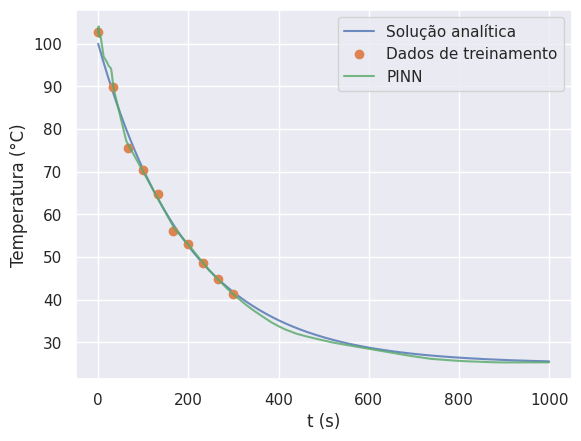

In [12]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Solução analítica','Dados de treinamento', 'PINN'])
plt.ylabel('Temperatura (°C)')
plt.xlabel('t (s)')

In [13]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT

    return torch.mean(pde**2)

In [14]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)

Epoch 0/40000, loss: 4816.01
Epoch 4000/40000, loss: 2501.69
Epoch 8000/40000, loss: 2074.12
Epoch 12000/40000, loss: 559.66
Epoch 16000/40000, loss: 4.16
Epoch 20000/40000, loss: 1.48
Epoch 24000/40000, loss: 1.06
Epoch 28000/40000, loss: 0.60
Epoch 32000/40000, loss: 0.39
Epoch 36000/40000, loss: 0.30


Descobrindo a taxa de decaimento $r$

In [16]:
preds = netdisc.predict(times)
print(f'A taxa de decaimento é r = {netdisc.r}')



A taxa de decaimento é r = Parameter containing:
tensor([0.0051], requires_grad=True)
